In [1]:
import random
random.seed(123)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
#import plotting stuff
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab

In [2]:
params = {'legend.fontsize': 'large',
          #'figure.figsize': (15,5),
          #'axes.grid' :True,
          #'grid.color' :'White',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':1}
pylab.rcParams.update(params)
sns.set_style("whitegrid")


In [22]:
df = pd.read_csv("../resources/data/nab/nab_machine_temperature/NAB_machine_temperature_system_failure.csv")

In [23]:
print "Data Range"
print "Start Date %s"%(df.head(1)['timestamp'])
print "End Date %s"%(df.tail(1)['timestamp'])

Data Range
Start Date 0    2013-12-02 21:15:00
Name: timestamp, dtype: object
End Date 22694    2014-02-19 15:25:00
Name: timestamp, dtype: object


In [24]:
print "num_values: %s"%(df.shape[0])

num_values: 22695


In [25]:
class SetColAsIndex(TransformerMixin):
    def __init__(self, col):
        self.col = col

    def transform(self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterCompleteDays(TransformerMixin):
    def __init__(self, n=96):
        self.n = n

    def transform(self, X, **transform_params):
        #print X.groupby(X.index.date).transform('count')
        X = X.ix[X.groupby(X.index.date).transform('count').iloc[:, 0] >= self.n]
        return X

    def fit(self, X, y=None, **fit_params):
        return self

class FilterDays(TransformerMixin):
    def __init__(self, days=None):
        self.days = days

    def transform(self, X, **transform_params):
        X = X.iloc[pd.Series(X.index.day).isin(self.days).values, :]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterWeekEnd(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X[X.index.weekday > 4]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class SortTimeSeries(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index()
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class RemoveDuplicateRow(TransformerMixin):
    def __init__(self, sample_period):
        self.sample_period = sample_period

    def transform(self, X, **transform_params):
        X = X.resample(self.sample_period, 'mean').fillna(method='bfill')
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [26]:
process_pipeline = make_pipeline(SetColAsIndex('timestamp'),
                                SortTimeSeries())
df = process_pipeline.fit_transform(df)
df = df.drop('timestamp', 1)

In [27]:
#add anomaly column
df['anomaly'] = 0
anomalies = ["2013-12-11 06:00:00","2013-12-16 17:25:00","2014-01-28 13:55:00","2014-02-08 14:30:00"]
for anomaly_date in anomalies:
    df.set_value(anomaly_date,'anomaly', 1)
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    print row[0],row[1],row[2]

2013-12-11 06:00:00 102.7362135 1
2013-12-16 17:25:00 2.084721206 1
2014-01-28 13:55:00 51.36715367 1
2014-02-08 14:30:00 25.88775208 1


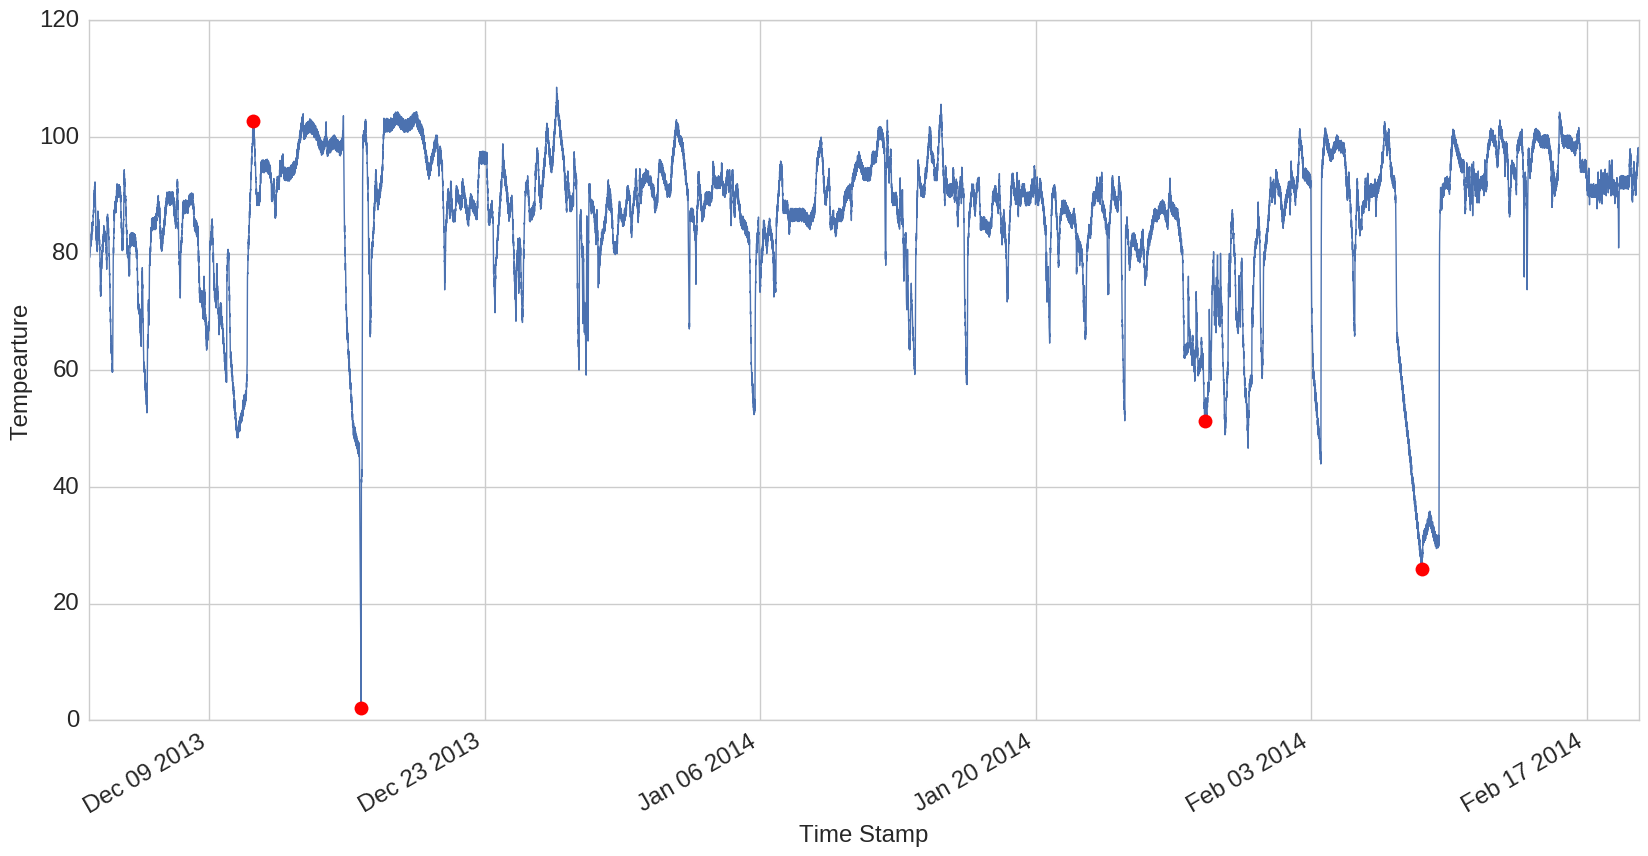

In [28]:
f1 = plt.figure(figsize=(20,10))
df['value'].plot()
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=20.0)
plt.xlabel("Time Stamp")
plt.ylabel("Tempearture")
plt.show()
pp = PdfPages('machine_temp_data.pdf')
pp.savefig(f1)
pp.close()

Size of test: 3168
Size of validation1: 864
Size of validation2: 2880
Size of train: 15783
Total: 22695
Ratio of test: 0.139590
Ratio of validation1: 0.038070
Ratio of validation2: 0.126900
Ratio of train: 0.695440
Pandas(Index=Timestamp('2013-12-11 06:00:00'), value=102.73621350000001, anomaly=1)
Pandas(Index=Timestamp('2013-12-16 17:25:00'), value=2.0847212060000002, anomaly=1)


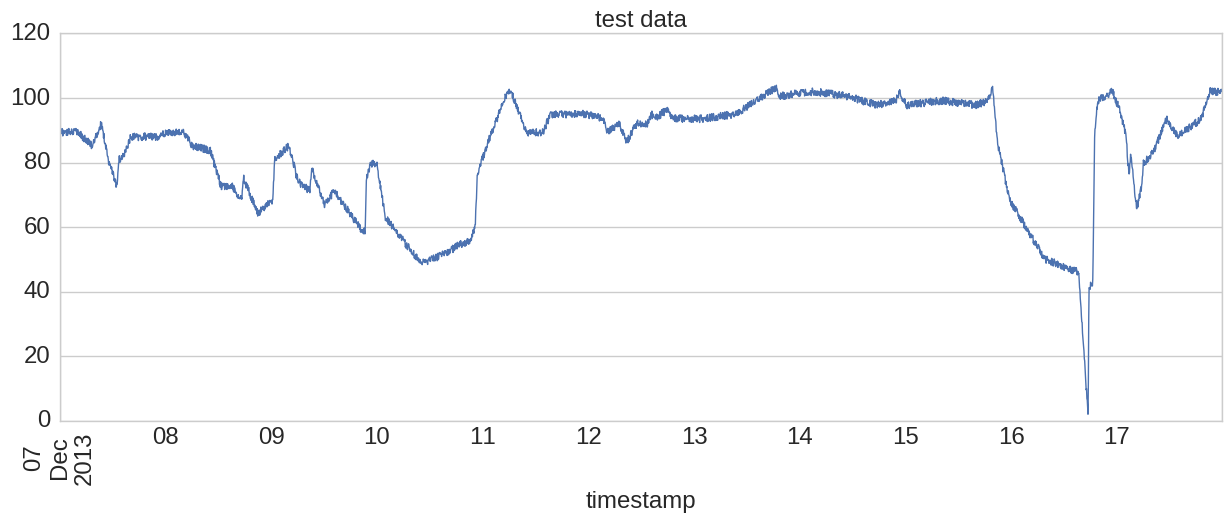

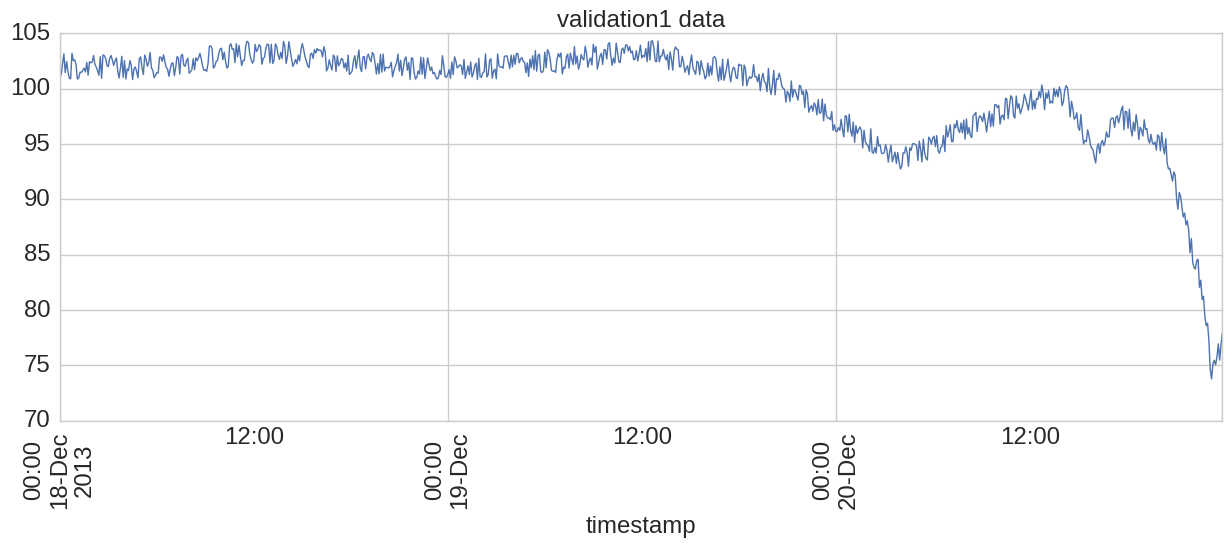

Pandas(Index=Timestamp('2014-01-28 13:55:00'), value=51.36715367, anomaly=1)
Pandas(Index=Timestamp('2014-02-08 14:30:00'), value=25.887752079999999, anomaly=1)


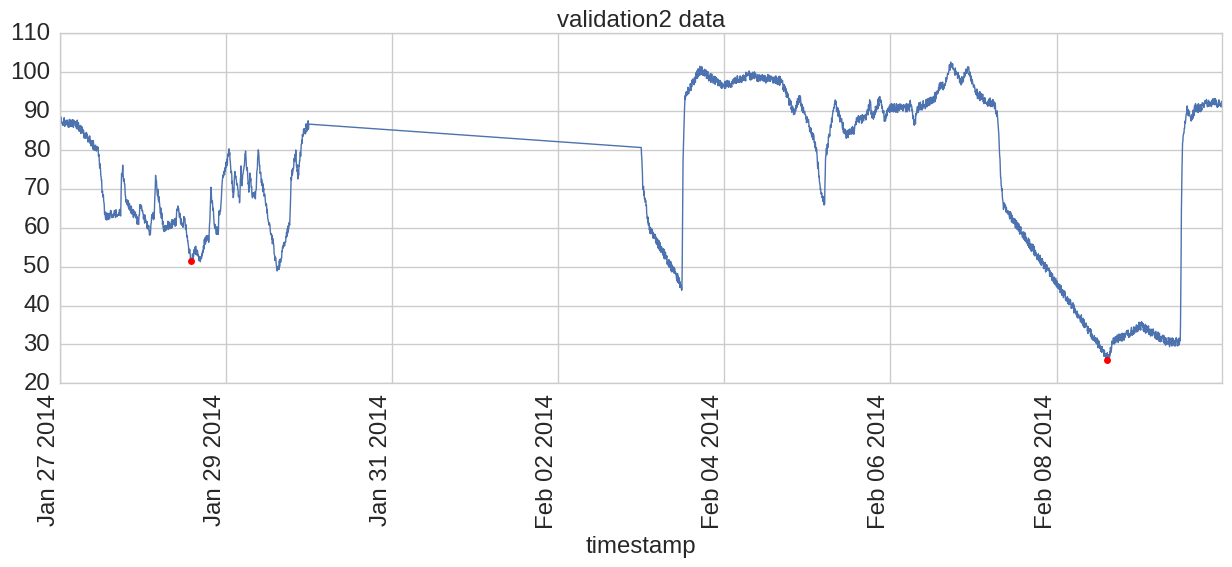

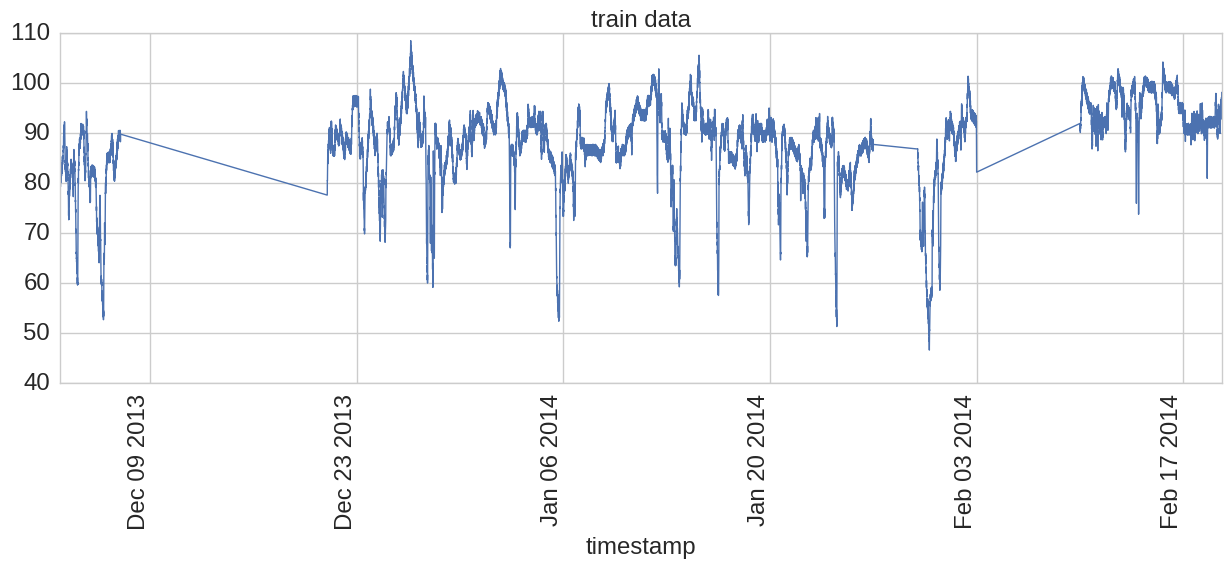

In [32]:
'''
Anomaly Dates: Dec 11, Dec16, Jan28, Feb8
'''
# df_validation_prediction = pd.concat([df['2013-12-13'],df['2013-12-18':'2013-12-20']])
# df_test = pd.concat([df['2013-12-09':'2013-12-12'],df['2013-12-14':'2013-12-17']])
df_validation_prediction = df['2013-12-18':'2013-12-20']
df_test = df['2013-12-07':'2013-12-17']
df_validation_anomaly = pd.concat([df['2014-01-27':'2014-01-29'],df['2014-02-03':'2014-02-09']])
df_not_train = pd.concat([df_validation_prediction,df_validation_anomaly,df_test])
df_train = df[~df.isin(df_not_train)].dropna()

df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation_prediction
df_dict['validation2'] = df_validation_anomaly

count = 0
for key in df_dict:
    print "Size of %s: %d"%(key,df_dict[key].shape[0])
    count += df_dict[key].shape[0]
print "Total: %d"%(count)

for key in df_dict:
    print "Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count)

    
for key in df_dict:
    df_tmp = df_dict[key]
    plt.figure()
    df_tmp['value'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        print row
        plt.plot(row[0], row[1], 'r.', markersize=10.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [33]:
for key in df_dict:
    np.save("../resources/data/nab/nab_machine_temperature/%s"%(key),df_dict[key])

In [34]:
## code below this not used

In [35]:
train = np.load("../resources/data/nab/nab_machine_temperature/train.npy")
validation1 = np.load("../resources/data/nab/nab_machine_temperature/validation1.npy")
validation2 = np.load("../resources/data/nab/nab_machine_temperature/validation2.npy")
test = np.load("../resources/data/nab/nab_machine_temperature/test.npy")
test_orig = test

In [36]:
print sum(train[:,1])
print sum(validation1[:,1])
print sum(validation2[:,1])
print sum(test[:,1])

0.0
0.0
2.0
2.0


In [37]:


data_folder = "../resources/data/nab/nab_machine_temperature/"
train = np.load(data_folder+"train.npy")
validation1 = np.load(data_folder+"validation1.npy")
validation2 = np.load(data_folder+"validation2.npy")
test = np.load(data_folder + "test.npy")


train,train_scaler = standardize(train[:,0])
validation1,validation1_scaler = standardize(validation1[:,0])
validation2_labels = validation2[:,1]
validation2,validation2_scaler = standardize(validation2[:,0])
test_labels = test[:,1]
test,test_scaler = standardize(test[:,0])

look_back = 5 
look_ahead = 3
X_train, y_train = prepare_seq2seq_data(train,look_back,look_ahead)
X_validation1, y_validation1 =  prepare_seq2seq_data(validation1,look_back,look_ahead)
X_validation2, y_validation2 =  prepare_seq2seq_data(validation2,look_back,look_ahead)
X_validation2_labels,y_validation2_labels = prepare_seq2seq_data(validation2_labels,look_back,look_ahead)
X_test, y_test = prepare_seq2seq_data(test,look_back,look_ahead)
X_test_labels,y_test_labels = prepare_seq2seq_data(test_labels,look_back,look_ahead)



NameError: name 'standardize' is not defined

In [126]:
#verify
print test_orig[440:460]
X_test = test_scaler.inverse_transform(X_test)
y_test = test_scaler.inverse_transform(y_test)
print X_test[440:460]
print y_test[440:460]


[[ 50.66362073   0.        ]
 [ 49.52384528   0.        ]
 [ 51.39930184   0.        ]
 [ 49.8900245    0.        ]
 [ 49.62962429   0.        ]
 [ 50.7098265    0.        ]
 [ 49.57538032   0.        ]
 [ 50.68119402   0.        ]
 [ 50.96837729   0.        ]
 [ 51.65297521   0.        ]
 [ 50.11470329   0.        ]
 [ 50.19045678   0.        ]
 [ 49.6258836    0.        ]
 [ 49.78787651   0.        ]
 [ 51.94215975   0.        ]
 [ 50.0099379    0.        ]
 [ 50.18637613   0.        ]
 [ 51.96366361   0.        ]
 [ 51.92270289   0.        ]
 [ 52.17244522   0.        ]]


NameError: name 'test_scaler' is not defined

In [127]:
print X_test_labels[440:460]
print y_test_labels[440:460]

NameError: name 'X_test_labels' is not defined

In [128]:
plt.figure()
plt.plot(range(1,len(y_test)+1),y_test[:,0])
anomalies = np.where(y_test_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_test[row,0], 'r.', markersize=10.0)
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
plt.figure()
plt.plot(range(1,len(y_validation2)+1),y_validation2[:,0])
anomalies = np.where(y_validation2_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_validation2[row,0], 'r.', markersize=10.0)
plt.show()

In [ ]:
plt.figure()
plt.plot(range(1,len(y_validation1)+1),y_validation1[:,0])
plt.show()

In [3]:
#Detection code starts here
#Detection code starts here
#Detection code starts here
#Detection code starts here

In [4]:
data_folder = "../resources/data/nab/nab_machine_temperature/"

In [5]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print train_predictions.shape
print train_true.shape


(15747, 12)
(15747,)


In [6]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print np.shape(validation2_predictions)
print np.shape(validation2_true)
print np.shape(validation2_labels)
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print np.shape(validation2_labels)


(2844, 12)
(2844,)
(2844, 12, 1)
(2844, 12)


In [7]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print np.shape(test_predictions)
print np.shape(test_true)
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print np.shape(test_labels)

(3132, 12)
(3132,)
(3132, 12)


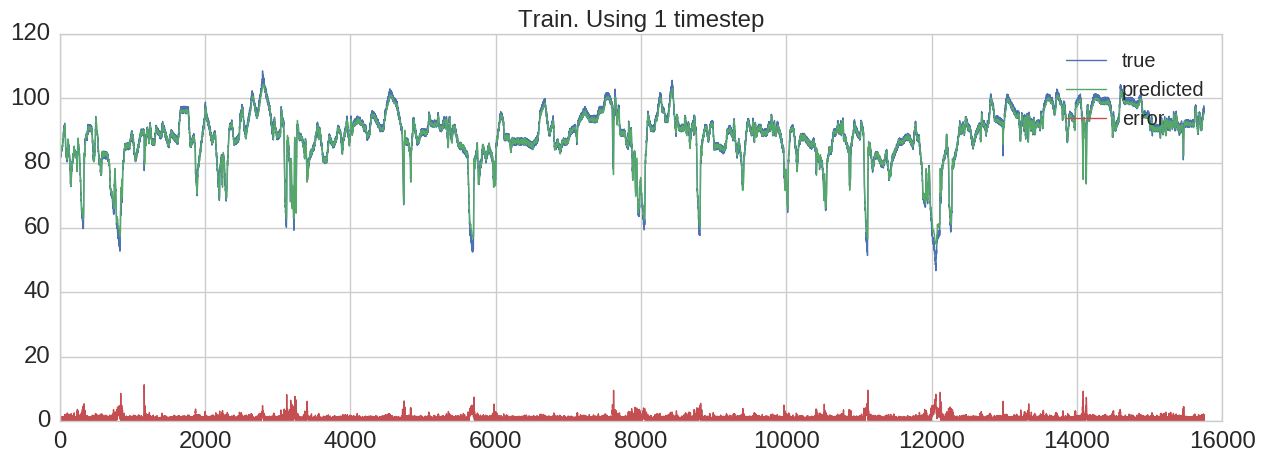

In [8]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

(15747, 1)
0.00705173186223
[[ 1.560521]]


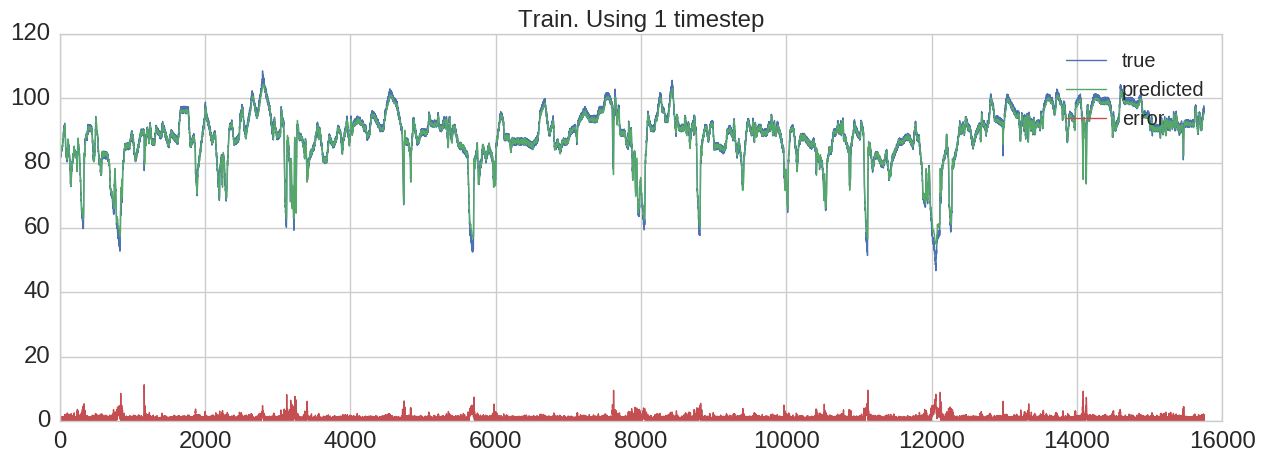

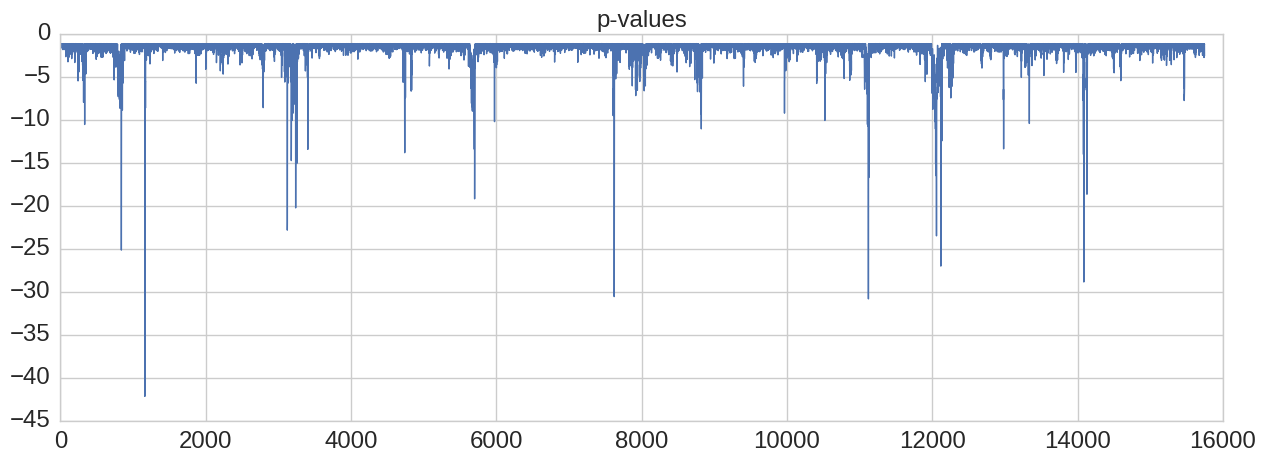

In [45]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

#ERROR DIMENSION
error_dimension = 1


train_error_vectors = train_error_vectors[:,0:error_dimension]
print np.shape(train_error_vectors)
mean = np.mean(train_error_vectors)
std = np.std(train_error_vectors)
print mean
print cov
p_values= norm(loc=mean, scale=std).logpdf(train_error_vectors)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [47]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_error_vectors = v2_error_vectors[:,0:error_dimension]
v2_p_values= norm(loc=mean, scale=std).logpdf(v2_error_vectors)
v2_true_anomalies = np.where(validation2_labels[:,0]==1)
print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
v2_thresholds =v2_p_values[v2_true_anomalies]
print "validation2. p-values at true anomalies: %s"%(v2_thresholds)


test_error_vectors = np.zeros(np.shape(test_predictions))

for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_error_vectors = test_error_vectors[:,0:error_dimension]
test_p_values= norm(loc=mean, scale=std).logpdf(test_error_vectors)
test_true_anomalies = np.where(test_labels[:,0]==1)
print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
print "Test. Location of anomalies: %s"%(test_true_anomalies)
print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
test_thresholds = test_p_values[test_true_anomalies]
print "Test. p-values at true anomalies: %s"%(test_thresholds)





Validation2. Number True Anomalies: 2
Validation2. Location of anomalies: [ 431 2454]
validation2. True anomalies: [ 51.36715367  25.88775208]
validation2. p-values at true anomalies: [[ -10.79043686]
 [-255.14695953]]
Test. Number True Anomalies in: 2
Test. Location of anomalies: [1200 2777]
Test. True anomalies: [ 102.7362135     2.08472121]
Test. p-values at true anomalies: [[  -2.53310292]
 [-885.70736818]]


(array([ 431, 2454]),)


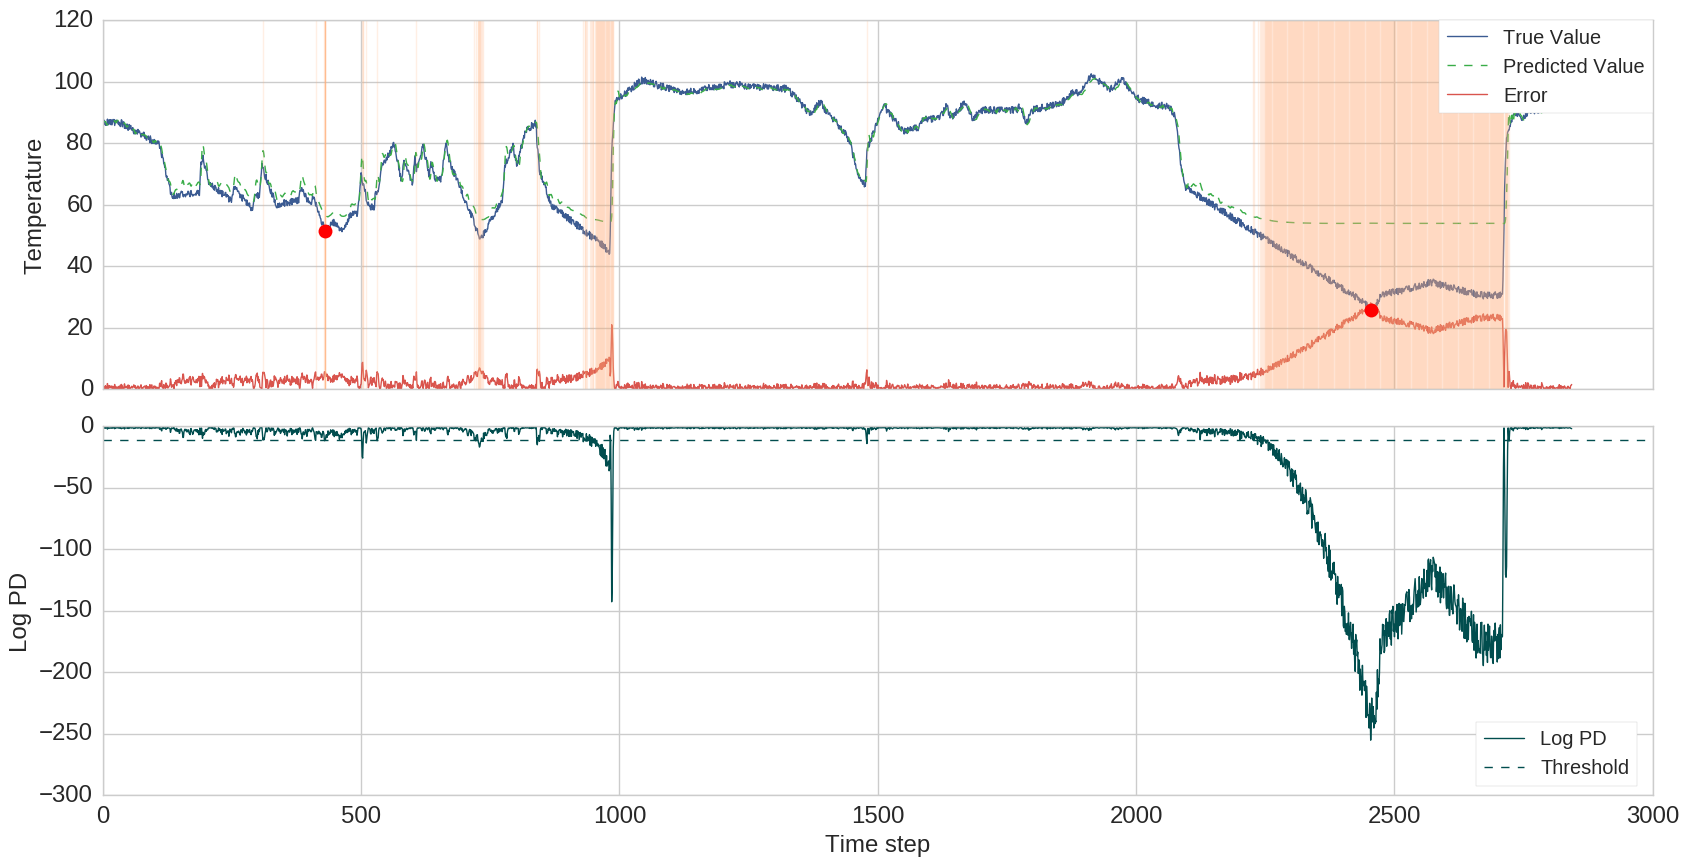

In [61]:
threshold_v2 = -11
v2_below_threshold = np.where(v2_p_values <= threshold_v2)

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.2)
ax1.axvline(x= v2_true_anomalies[0][0],color=sns.xkcd_rgb["peach"],alpha=.8)
for row in v2_true_anomalies:
    print v2_true_anomalies
    ax1.plot(row, validation2_true[row], 'r.', markersize=20.0)

plt.ylabel("Temperature")
ax1.legend(bbox_to_anchor=(1,1),borderaxespad=0.,frameon=True)
#plt.title("Validation2. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
#plt.title("Validation2 p-values")
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"],)
ax2.legend(bbox_to_anchor=(.99, 0.2), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()

pp = PdfPages('machine_temp_v2.pdf')
pp.savefig(f)
pp.close()

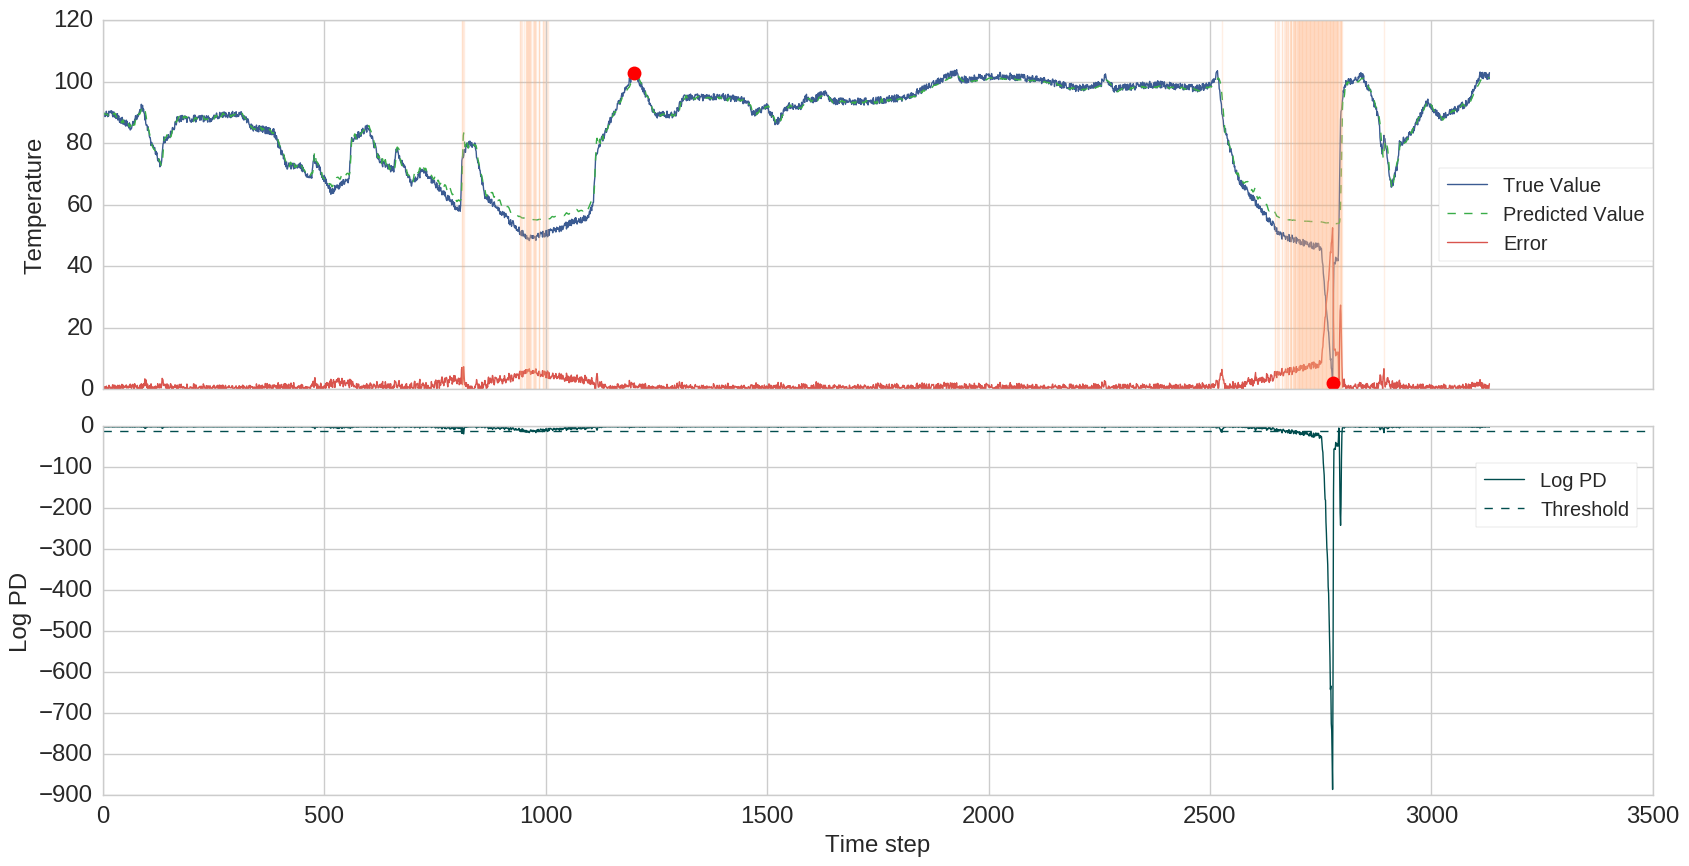

In [62]:

test_below_threshold = np.where(test_p_values <= threshold_v2)

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.2)
for row in test_true_anomalies:
    ax1.plot(row, test_true[row], 'r.', markersize=20.0)
plt.ylabel("Temperature")
ax1.legend(bbox_to_anchor=(1,.6),borderaxespad=0.,frameon=True)
#plt.title("test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
#plt.title("test p-values")
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"],)
ax2.legend(bbox_to_anchor=(.99, .9), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()

pp = PdfPages('machine_temp_test.pdf')
pp.savefig(f)
pp.close()
# plt.figure(figsize=(15,5))
# plt.plot(test_true,label='true')
# plt.plot(test_predictions[:,0],label='predicted')
# plt.plot(abs(test_true - test_predictions[:,0]),label='error')
# for row in test_true_anomalies:
#     plt.plot(row, test_true[row], 'r.', markersize=20.0)
# for column in test_below_threshold[0]:
#     plt.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
# plt.legend()
# plt.title("Test. Using 1 timestep")
# plt.show()

# plt.figure(figsize=(15,5))
# plt.plot(test_p_values)
# plt.title("test p-values")
# plt.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
# plt.show()

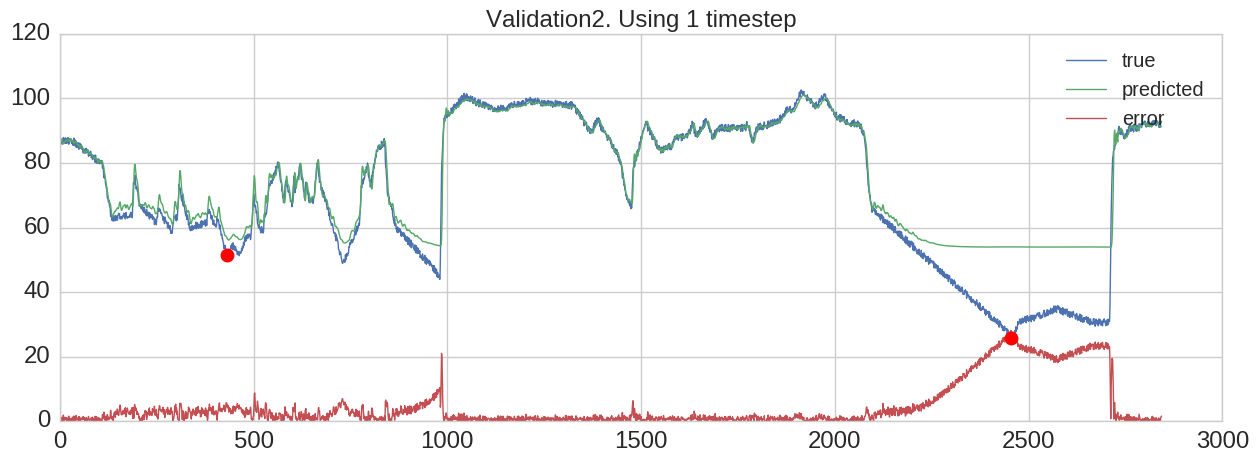

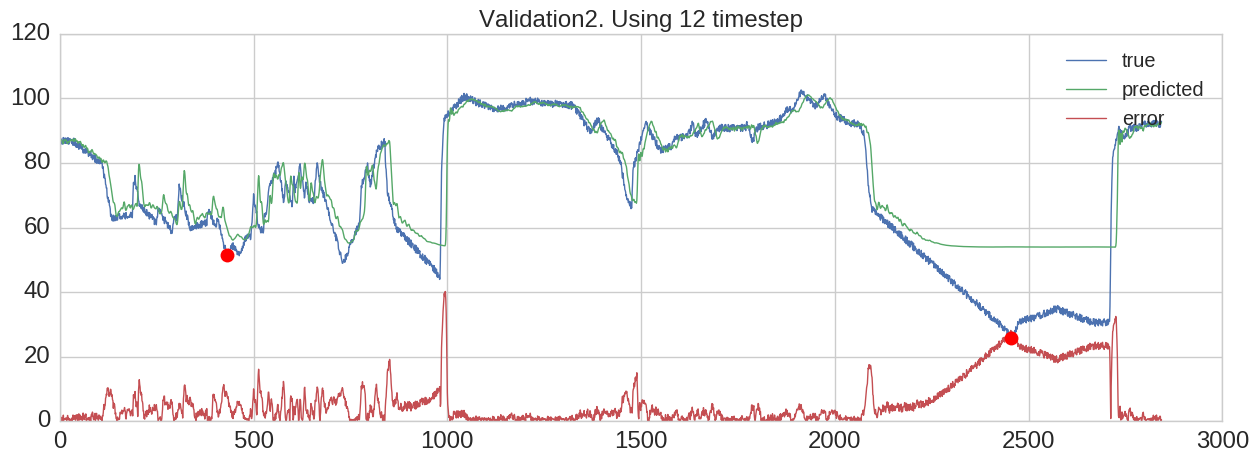

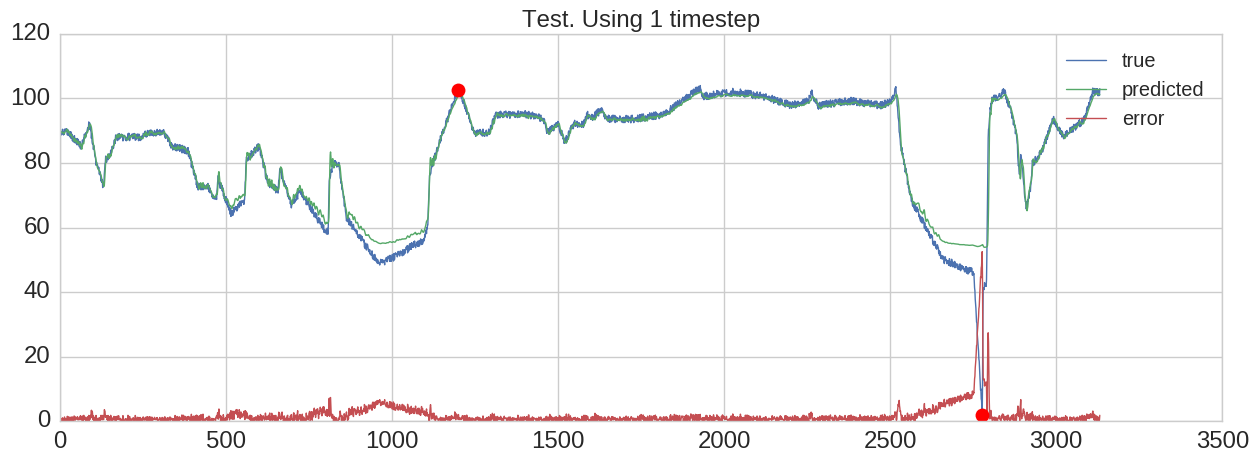

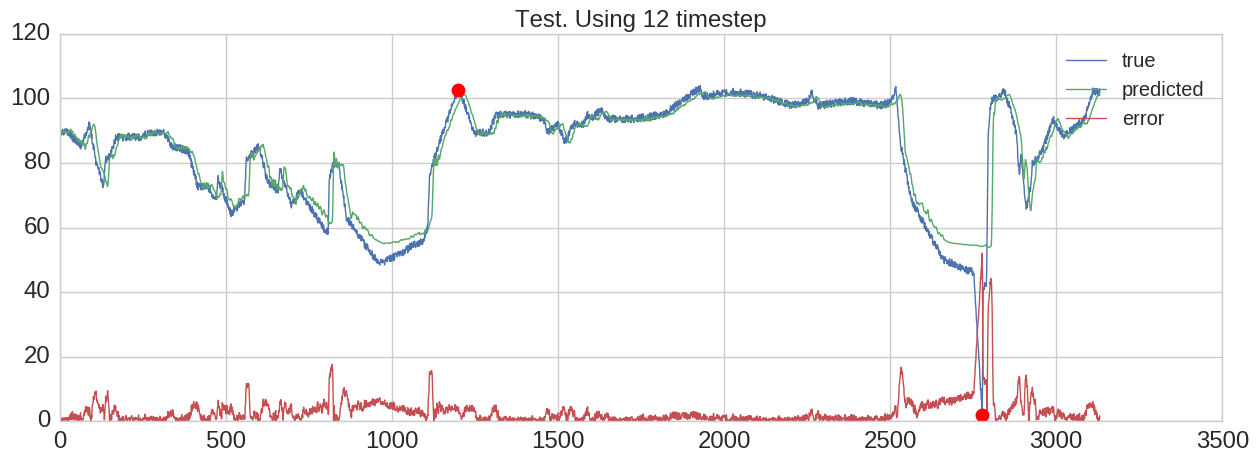

In [21]:
plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,0],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,11],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,11]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 12 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,0],label='predicted')
plt.plot(abs(test_true - test_predictions[:,0]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,11],label='predicted')
plt.plot(abs(test_true - test_predictions[:,11]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 12 timestep")
plt.show()


Candidate Thresholds: [-40, -45, -50]


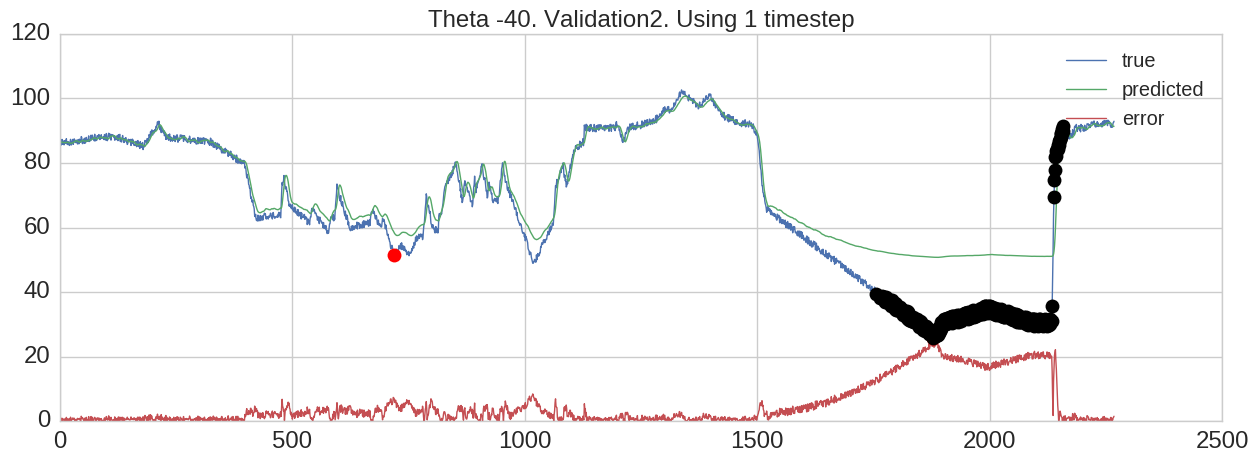

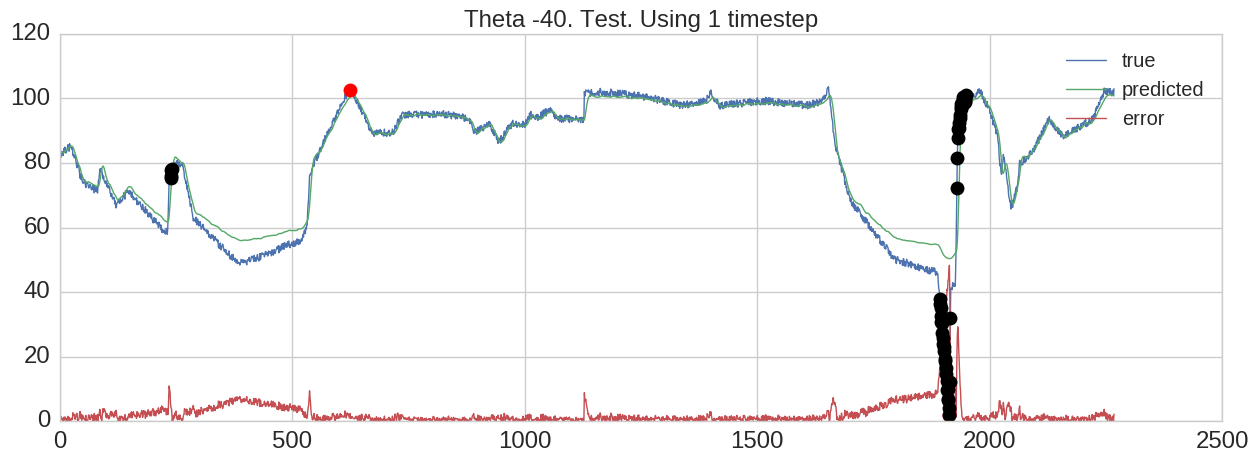

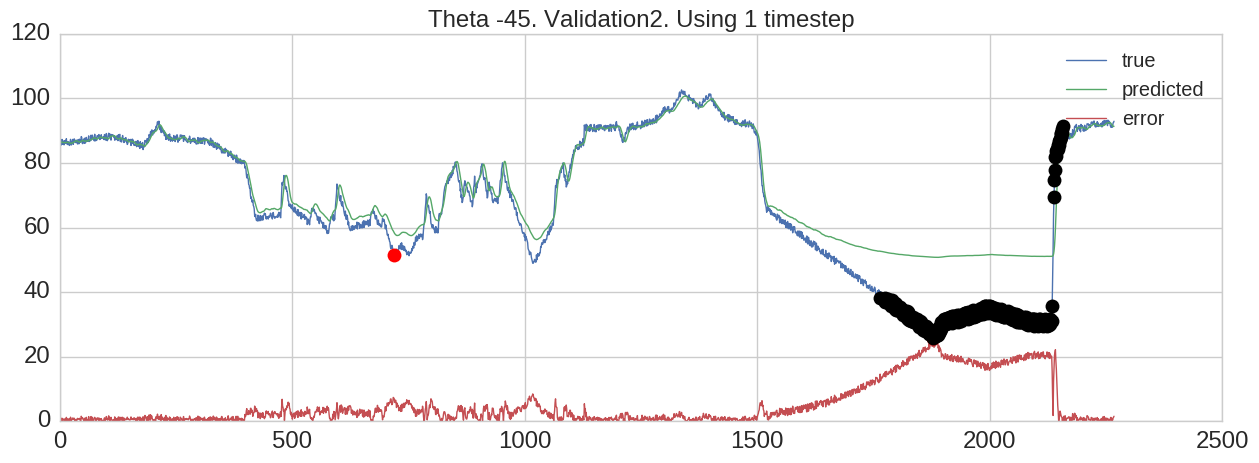

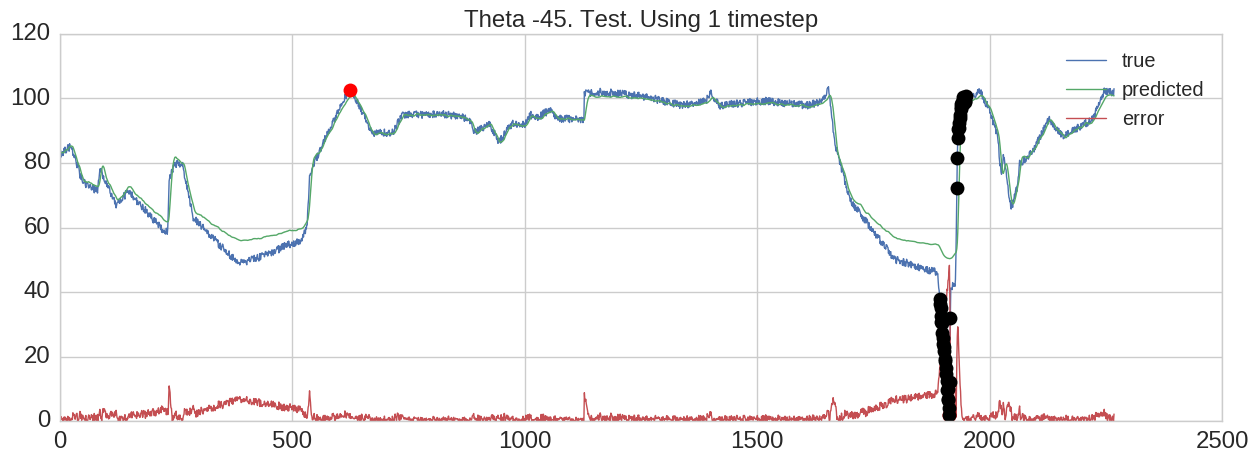

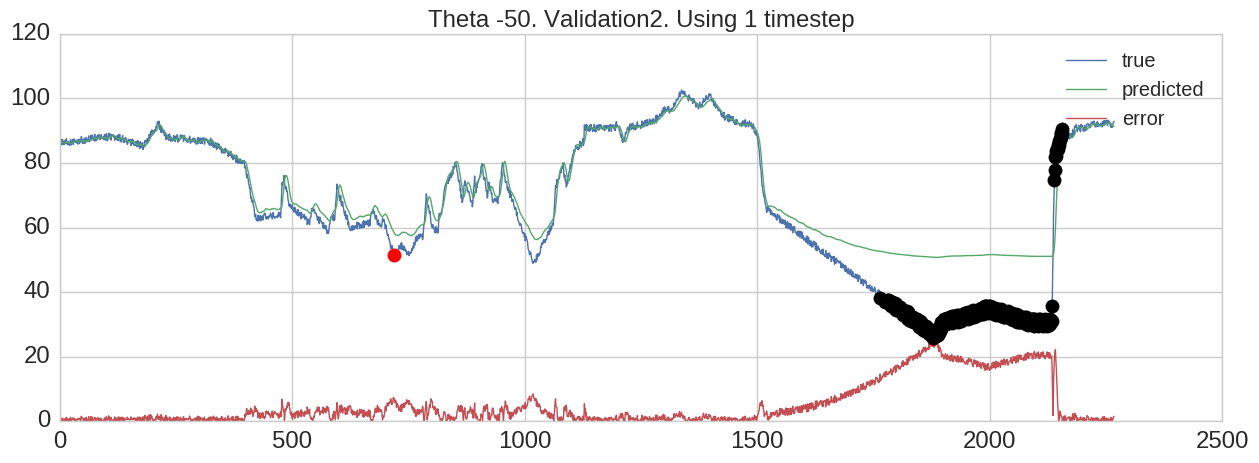

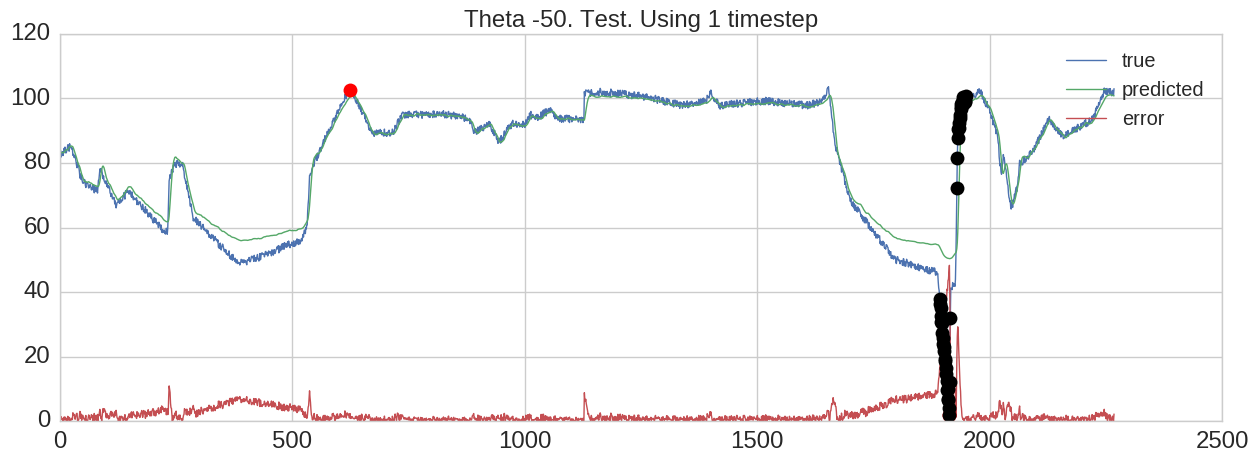

In [238]:
#thresholds = np.append(v2_thresholds,test_thresholds)

#thresholds =v2_thresholds
thresholds =[-40,-45,-50]
print
print "Candidate Thresholds: %s"%(thresholds)


for i in thresholds:
    theta= i
    test_potential_anomalies = np.where(test_p_values <= theta)
    v2_potential_anomalies = np.where(v2_p_values <= theta)
    plt.figure(figsize=(15,5))
    plt.plot(validation2_true,label='true')
    plt.plot(validation2_predictions[:,0],label='predicted')
    plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
    for row in v2_true_anomalies:
        plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
    for row in v2_potential_anomalies:
        plt.plot(row, validation2_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Validation2. Using 1 timestep"%(i))
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_true,label='true')
    plt.plot(test_predictions[:,0],label='predicted')
    plt.plot(abs(test_true - test_predictions[:,0]),label='error')
    for row in test_true_anomalies:
        plt.plot(row, test_true[row], 'r.', markersize=20.0)
    for row in test_potential_anomalies:
        plt.plot(row, test_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Test. Using 1 timestep"%(i))
    plt.show()





In [57]:
theta= -50
test_predicted_anomalies = test_p_values <= theta
v2_predicted_anomalies = [1 if x <= theta else 0 for x in v2_p_values]
print np.shape(validation2_labels)
print fbeta_score(validation2_labels[:,0],v2_predicted_anomalies,pos_label=0, average='binary', beta=.5)
print 

(2268, 12)
0.960754332314



(16899, 12)
[-0.05010486 -0.04926056 -0.04842562 -0.04760648 -0.04679409 -0.0460188
 -0.04524672 -0.04449229 -0.04375981 -0.0430334  -0.04230559 -0.04158811]
(12, 12)
[ 3269.08238281  1570.37414434    87.16483647 ...,    51.46927419
    56.19545178    13.7953319 ]
(16899,)


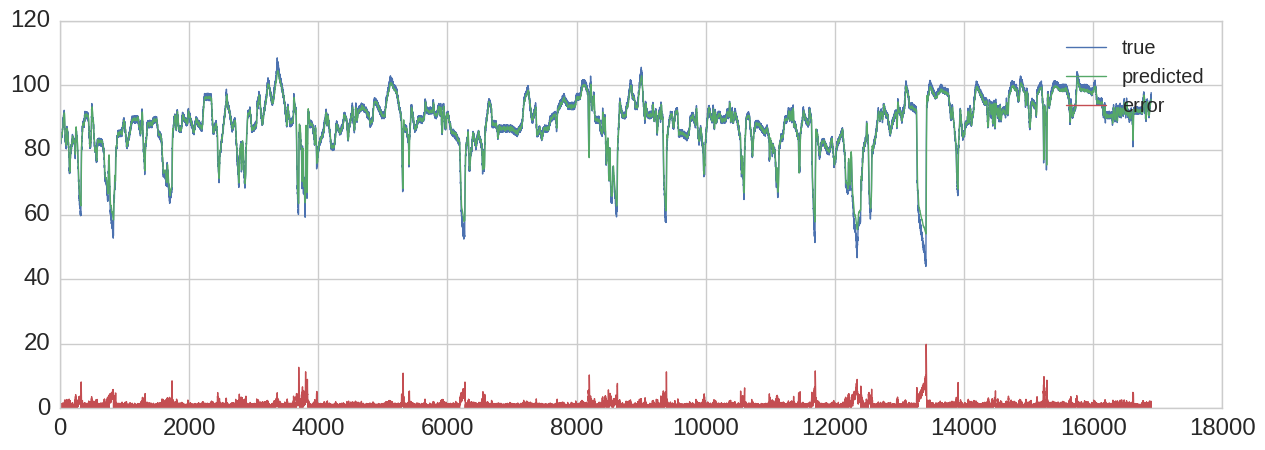

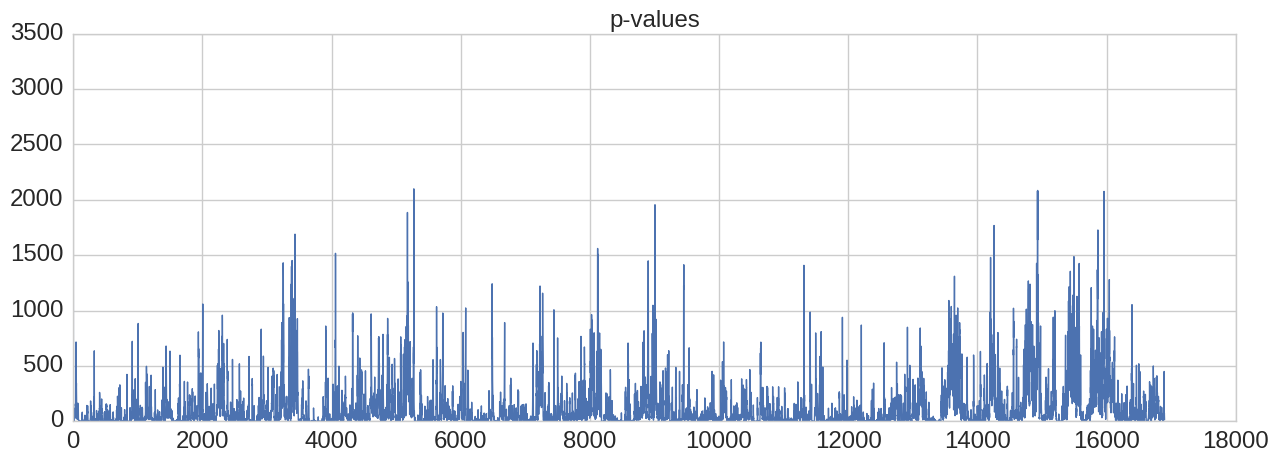

In [58]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]
# print validation2_predictions[100:102]
# print validation2_true[100:102]
# print v2_error_vectors[100:102]
print np.shape(train_error_vectors)
mean = np.mean(train_error_vectors, axis=0)
print mean
cov = np.cov(train_error_vectors,rowvar=False)
print np.shape(cov)
p_values= multivariate_normal.pdf(train_error_vectors,mean,cov)
print p_values
print np.shape(p_values)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

In [59]:
print validation2_predictions[100]
print validation2_true[100]

[ 87.64954376  87.8073349   87.92277527  87.89028168  87.74877167
  87.86014557  87.83717346  87.85015106  87.87163544  87.95049286
  88.0016098   87.91244507]
89.10841282


In [60]:
print validation2_predictions[100] - validation2_true[100]

[-1.45886993 -1.3010788  -1.18563843 -1.21813202 -1.35964203 -1.24826813
 -1.27124023 -1.25826263 -1.23677826 -1.15792084 -1.10680389 -1.19596863]


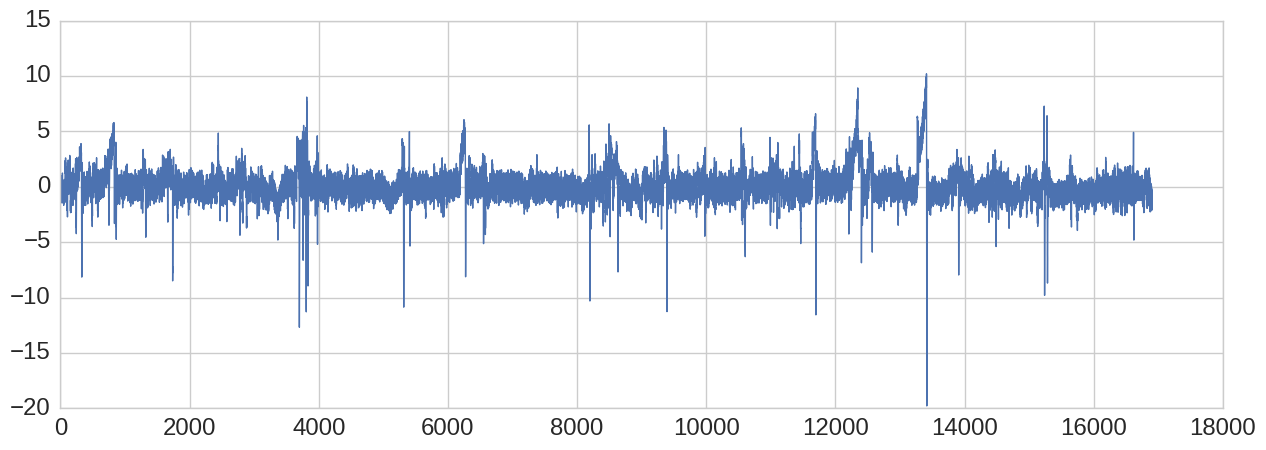

In [61]:
#using prediction intervals
#use first timestep
from scipy.stats import t
p = 95
alpha = (100-p)/100

train_errors = train_predictions[:,0] - train_true
n = np.shape(train_errors)[0]
s =  np.std(train_errors)
plt.plot(train_errors)
plt.show()
